<a href="https://colab.research.google.com/github/miramnair/BritishAirways-Review-webscrapping-and-topicmodelling-using-kmeans-clustering/blob/main/Webscraping_topicmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Web scraping and analysis

We will use a package called `BeautifulSoup` to collect the data from the web.

### Scraping data

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see reviews related to British Airways and the Airline itself. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [15]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 375

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 375 total reviews
Scraping page 2
   ---> 750 total reviews
Scraping page 3
   ---> 1125 total reviews
Scraping page 4
   ---> 1500 total reviews
Scraping page 5
   ---> 1875 total reviews
Scraping page 6
   ---> 2250 total reviews
Scraping page 7
   ---> 2625 total reviews
Scraping page 8
   ---> 3000 total reviews
Scraping page 9
   ---> 3375 total reviews
Scraping page 10
   ---> 3750 total reviews


In [16]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | I upgraded at check in to C...
1,✅ Trip Verified | I bought a return trip with...
2,✅ Trip Verified | Poor from start to finish. ...
3,✅ Trip Verified | Communication and customer s...
4,✅ Trip Verified | That was supposed to be my ...


Now we have your dataset for this task! The loops above collected 3745 reviews by iterating through the paginated pages on the website.

 The next thing that we should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

LET'S START DATA PROCESSING!!!!

Below we have created a function to enhance the clarity of reviews by removing the "Trip Verified" and "Not Verified" status. It's important to note that not all reviews include these status labels. During manual inspection of the downloaded CSV file, it can be observed that a "|" symbol is present in reviews with verified or not verified status. Therefore, we can leverage the "|" symbol as a marker to extract and strip away the status information from each comment.

In [17]:
# Function to remove verified and Not Verified status
def process_review(row):
    if '|' in row:
        return row.split('|',1)[1].strip()
    else :
        return row

df['reviews'] = df['reviews'].apply(process_review)

In [18]:
df.head()

,reviews
0,I upgraded at check in to Club Europe seat 1D ...
1,"I bought a return trip with BA, through Webjet..."
2,Poor from start to finish. Six months after pu...
3,Communication and customer service non existen...
4,That was supposed to be my flight but it was c...


Text Preprocessing for NLP

As I reviewed the feedback, I observed numerous instances of flight numbers and alphanumeric characters, which are unnecessary for our analysis. The next step involves eliminating these digits and alphanumeric words, along with removing stopwords and punctuation.


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop = stopwords.words("english")

def remove_stopwords_punc(texts):
    pattern = r'\b(?:\d+|\w*\d\w*)\b' #remove digits and alphanumeric words
    text = re.sub(pattern, '', texts)
    words = text.split()
    final = []
    final = " ".join([word for word in words if word.lower() not in stop]) #remove stopwords
    final = "".join([word for word in final if word not in string.punctuation]) #remove punctutaion
    return final

df["clean_reviews"] = df["reviews"].apply(remove_stopwords_punc)

In [21]:
df["clean_reviews"][0:7]

0    upgraded check Club Europe seat excellent expe...
1    bought return trip BA Webjet Australia last ye...
2    Poor start finish Six months purchasing ticket...
3    Communication customer service non existent ma...
4    supposed flight cancelled hours takeoff nearly...
5    fear BA flight operated Finnair business class...
6    flown BA five times western USA England Always...
Name: clean_reviews, dtype: object

To enhance the cleanliness of our data, we can take one final step by lemmatizing the reviews.

In [22]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()


def lemmatizing(text):
    lemmatized_text = " ".join([lm.lemmatize(word.lower()) for word in text.split()])
    return lemmatized_text

df["clean_reviews_lemma"] = df["clean_reviews"].apply(lambda x : lemmatizing(x))

df["clean_reviews_lemma"][0:7]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    upgraded check club europe seat excellent expe...
1    bought return trip ba webjet australia last ye...
2    poor start finish six month purchasing ticket ...
3    communication customer service non existent ma...
4    supposed flight cancelled hour takeoff nearly ...
5    fear ba flight operated finnair business class...
6    flown ba five time western usa england always ...
Name: clean_reviews_lemma, dtype: object

In [35]:
vectorizer = TfidfVectorizer(
                                lowercase=True,
                                max_features=500,   #select 500 features
                                max_df=0.3,
                                min_df=3,
                                ngram_range = (1,3),
                                stop_words = "english"

                            )


vectors = vectorizer.fit_transform(df["clean_reviews_lemma"])

feature_names = vectorizer.get_feature_names_out()

dense = vectors.todense()
denselist = dense.tolist()



In [41]:
#denselist is a list of lists with each list representing a review
print(len(denselist))

#Each list within a denselist will have 500 features
print(len(denselist[0]))
print(len(denselist[3749]))

3750
500
500


In [42]:
df_keywords = pd.DataFrame(data=dense, columns=feature_names)

# Display the resulting DataFrame
df_keywords.head()

,able,absolutely,access,actually,additional,afternoon,agent,ago,ahead,air,...,work,worked,working,world,world traveller,worse,worst,worth,wrong,year
0,0.000000,0.0,0.0,0.0,0.0,0.203445,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.232562
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.181067,0.000000,0.0,0.183538,0.000000
3,0.200775,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.188551,0.0,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.182138,0.0,0.000000,0.000000


To better analyze we can print the Keywords that was extracted from Original Text Using TF-IDF Values

In [45]:
all_keywords = []
for description in denselist:
    x = 0
    keywords = []
    for word in description:
        if word > 0:
            keywords.append(feature_names[x])
        x= x + 1
    all_keywords.append(keywords)

print(df["clean_reviews"][0]) #original data
print(all_keywords[0]) #key words of original text


upgraded check Club Europe seat excellent experience BA checkin airport quick smooth friendly staff fast track headed Galleries lounge LHR exceeded expectations food really good superb view runway flight great people remarked legroom isn’t good even Club Europe found fine hour flight ‘Afternoon tea’ delicious Cabin crew excellent airport minutes landing BA superb job flight
['afternoon', 'airport', 'cabin crew', 'check', 'checkin', 'club', 'club europe', 'europe', 'excellent', 'experience', 'fast', 'fast track', 'fine', 'friendly', 'great', 'hour flight', 'job', 'landing', 'legroom', 'lhr', 'lounge', 'minute', 'people', 'quick', 'really', 'smooth', 'tea', 'track']


**Top Terms in Each Cluster Identified by K-Means Clustering**

In [46]:
k = 3
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(vectors)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
   print(f"Cluster {i}")
   for ind in order_centroids[i, :15]:
       print('%s' % terms[ind], end=', ')
   print()  # Print a new line after each cluster's top terms


Cluster 0
customer, day, told, customer service, bag, cancelled, airport, luggage, check, delayed, booked, refund, ticket, delay, minute, 
Cluster 1
drink, economy, meal, club, cabin crew, return, plane, aircraft, comfortable, lounge, passenger, great, friendly, boarding, experience, 
Cluster 2
class, business, business class, economy, lounge, club, class seat, passenger, business class seat, poor, meal, like, experience, fly, better, 


**2D Scatter Plot of Data Points Using PCA and K-Means Clustering**

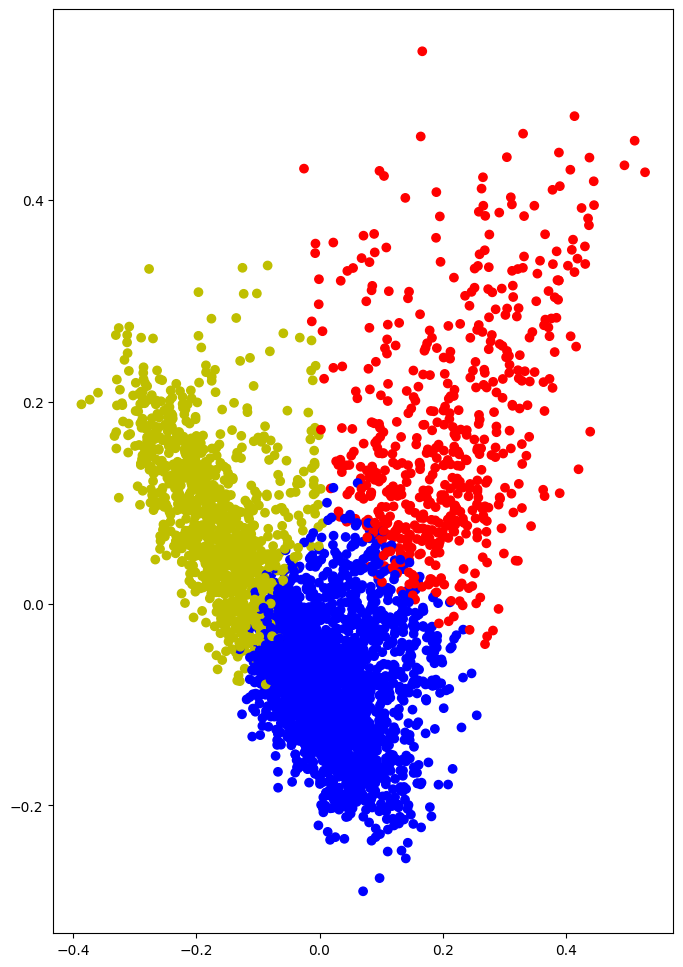

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmean_indices = model.fit_predict(vectors)

pca = PCA(n_components =2)
scatter_plot_points = pca.fit_transform(vectors.toarray())

colors = ["r", "b", "y"]


x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(8,12))

ax.scatter(x_axis,y_axis, c = [colors[d] for d in kmean_indices])





**Word Clouds for Each Cluster Based on K-Means Clustering**

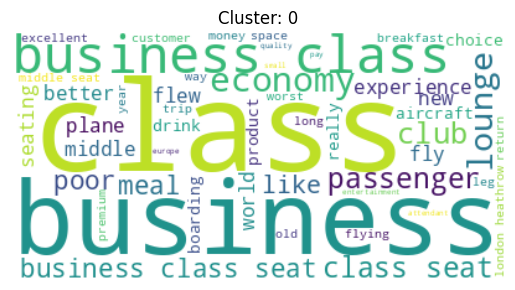

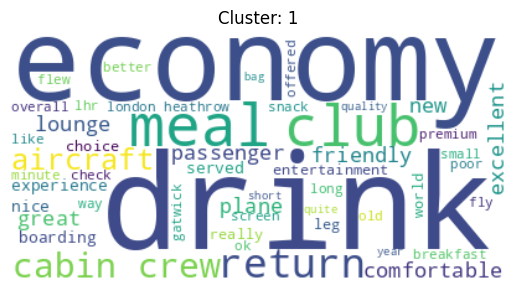

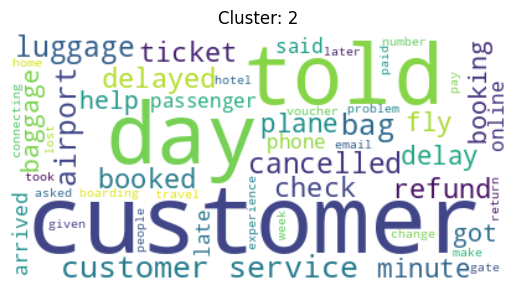

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of clusters
K = 3
centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()


# Function to get term frequencies for a cluster
def get_cluster_frequencies(cluster_index):
    if cluster_index >= K:
        return None
    term_frequencies = model.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

# Function to create and display a word cloud
def display_wordcloud(frequencies):
    wordcloud = WordCloud(background_color="white", max_words=50)
    wordcloud.generate_from_frequencies(frequencies)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Generate and display word clouds for each cluster
for i in range(K):
    frequencies = get_cluster_frequencies(i)
    if frequencies:
        plt.title(f"Cluster: {i}")
        display_wordcloud(frequencies)
        print()
